In [1]:
#Import libraries
from fastai.vision import Path,get_image_files,open_image,get_transforms,ImageDataBunch,imagenet_stats,cnn_learner,models,ClassificationInterpretation
import pandas as pd
import numpy as np
import warnings
from fastai.metrics import error_rate


warnings.filterwarnings('ignore')
np.random.seed(2)

# Analysing Data

In [2]:
#Setting dataset path 
base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
images_path = base_path/'images'
base_path.ls()

[PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'),
 PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles'),
 PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'),
 PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset'),
 PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv')]

In [3]:
#Get total images in dataset
total_images = get_image_files(images_path)
len(total_images),total_images[:5]


(44441,
 [PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/21568.jpg'),
  PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/59366.jpg'),
  PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/47488.jpg'),
  PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/21182.jpg'),
  PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/24229.jpg')])

In [4]:
# Get label information from CSV
df = pd.read_csv(base_path/'styles.csv',error_bad_lines=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [5]:
# Look at data
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
#Map images with catagory
df_label = pd.DataFrame(columns=['name','label'])
df_label['label'] = df['articleType'].astype(str) +"-"+df['gender'].astype(str)+"-"+df['subCategory'].astype(str) +"-"+df['masterCategory']
df_label['name'] = df['id'].astype(str) + str(".jpg")
df_label.head()

,name,label
0,15970.jpg,Shirts-Men-Topwear-Apparel
1,39386.jpg,Jeans-Men-Bottomwear-Apparel
2,59263.jpg,Watches-Women-Watches-Accessories
3,21379.jpg,Track Pants-Men-Bottomwear-Apparel
4,53759.jpg,Tshirts-Men-Topwear-Apparel


In [7]:
#Printing images that don't exist from the dataframe
invalid_img = []
for idx,value in enumerate(df_label.name):
    path = images_path/str(value)
    if not path.is_file():
        invalid_img.append(idx)
        print(idx,path)
invalid_img

6695 /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39403.jpg
16194 /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39410.jpg
32309 /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39401.jpg
36381 /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39425.jpg
40000 /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12347.jpg


[6695, 16194, 32309, 36381, 40000]

In [8]:
#Removing invalid images from dataframe
df_processed = df_label.drop(df_label.index[invalid_img])
print(df_processed.info())
for idx,value in enumerate(df_processed.name):
    path = images_path/str(value)
    if not path.is_file():
        print(idx,path)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44419 entries, 0 to 44423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    44419 non-null  object
 1   label   44419 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None


In [9]:
#Printing distinct catagories
len(df_processed.label.unique())

313

In [10]:
#Shortlisting catogories based on number of images available
get_top_cat=df_processed.groupby('label')['name'].count().nlargest(100)
top_cat_dict=get_top_cat.to_dict()
valid_labels = list(top_cat_dict.keys())
valid_labels

['Tshirts-Men-Topwear-Apparel',
 'Shirts-Men-Topwear-Apparel',
 'Casual Shoes-Men-Shoes-Footwear',
 'Kurtas-Women-Topwear-Apparel',
 'Handbags-Women-Bags-Accessories',
 'Sports Shoes-Men-Shoes-Footwear',
 'Tops-Women-Topwear-Apparel',
 'Watches-Men-Watches-Accessories',
 'Heels-Women-Shoes-Footwear',
 'Tshirts-Women-Topwear-Apparel',
 'Watches-Women-Watches-Accessories',
 'Sandals-Men-Sandal-Footwear',
 'Formal Shoes-Men-Shoes-Footwear',
 'Backpacks-Unisex-Bags-Accessories',
 'Sunglasses-Men-Eyewear-Accessories',
 'Briefs-Men-Innerwear-Apparel',
 'Belts-Men-Belts-Accessories',
 'Socks-Men-Socks-Accessories',
 'Tshirts-Boys-Topwear-Apparel',
 'Flats-Women-Shoes-Footwear',
 'Flip Flops-Men-Flip Flops-Footwear',
 'Bra-Women-Innerwear-Apparel',
 'Wallets-Women-Wallets-Accessories',
 'Wallets-Men-Wallets-Accessories',
 'Trousers-Men-Bottomwear-Apparel',
 'Sarees-Women-Saree-Apparel',
 'Earrings-Women-Jewellery-Accessories',
 'Sports Shoes-Women-Shoes-Footwear',
 'Dresses-Women-Dress-Apparel

In [11]:
# Storing top 100 category as dataframe
rows=[] 
for index, row in df_processed.iterrows():
    if row['label'] in valid_labels:
        temp_dict = {'name':row['name'],
                    'label':row['label']}
        rows.append(temp_dict)
        
df_100 = pd.DataFrame(rows)  
df_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42114 entries, 0 to 42113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    42114 non-null  object
 1   label   42114 non-null  object
dtypes: object(2)
memory usage: 658.2+ KB


Shirts-Men-Topwear-Apparel


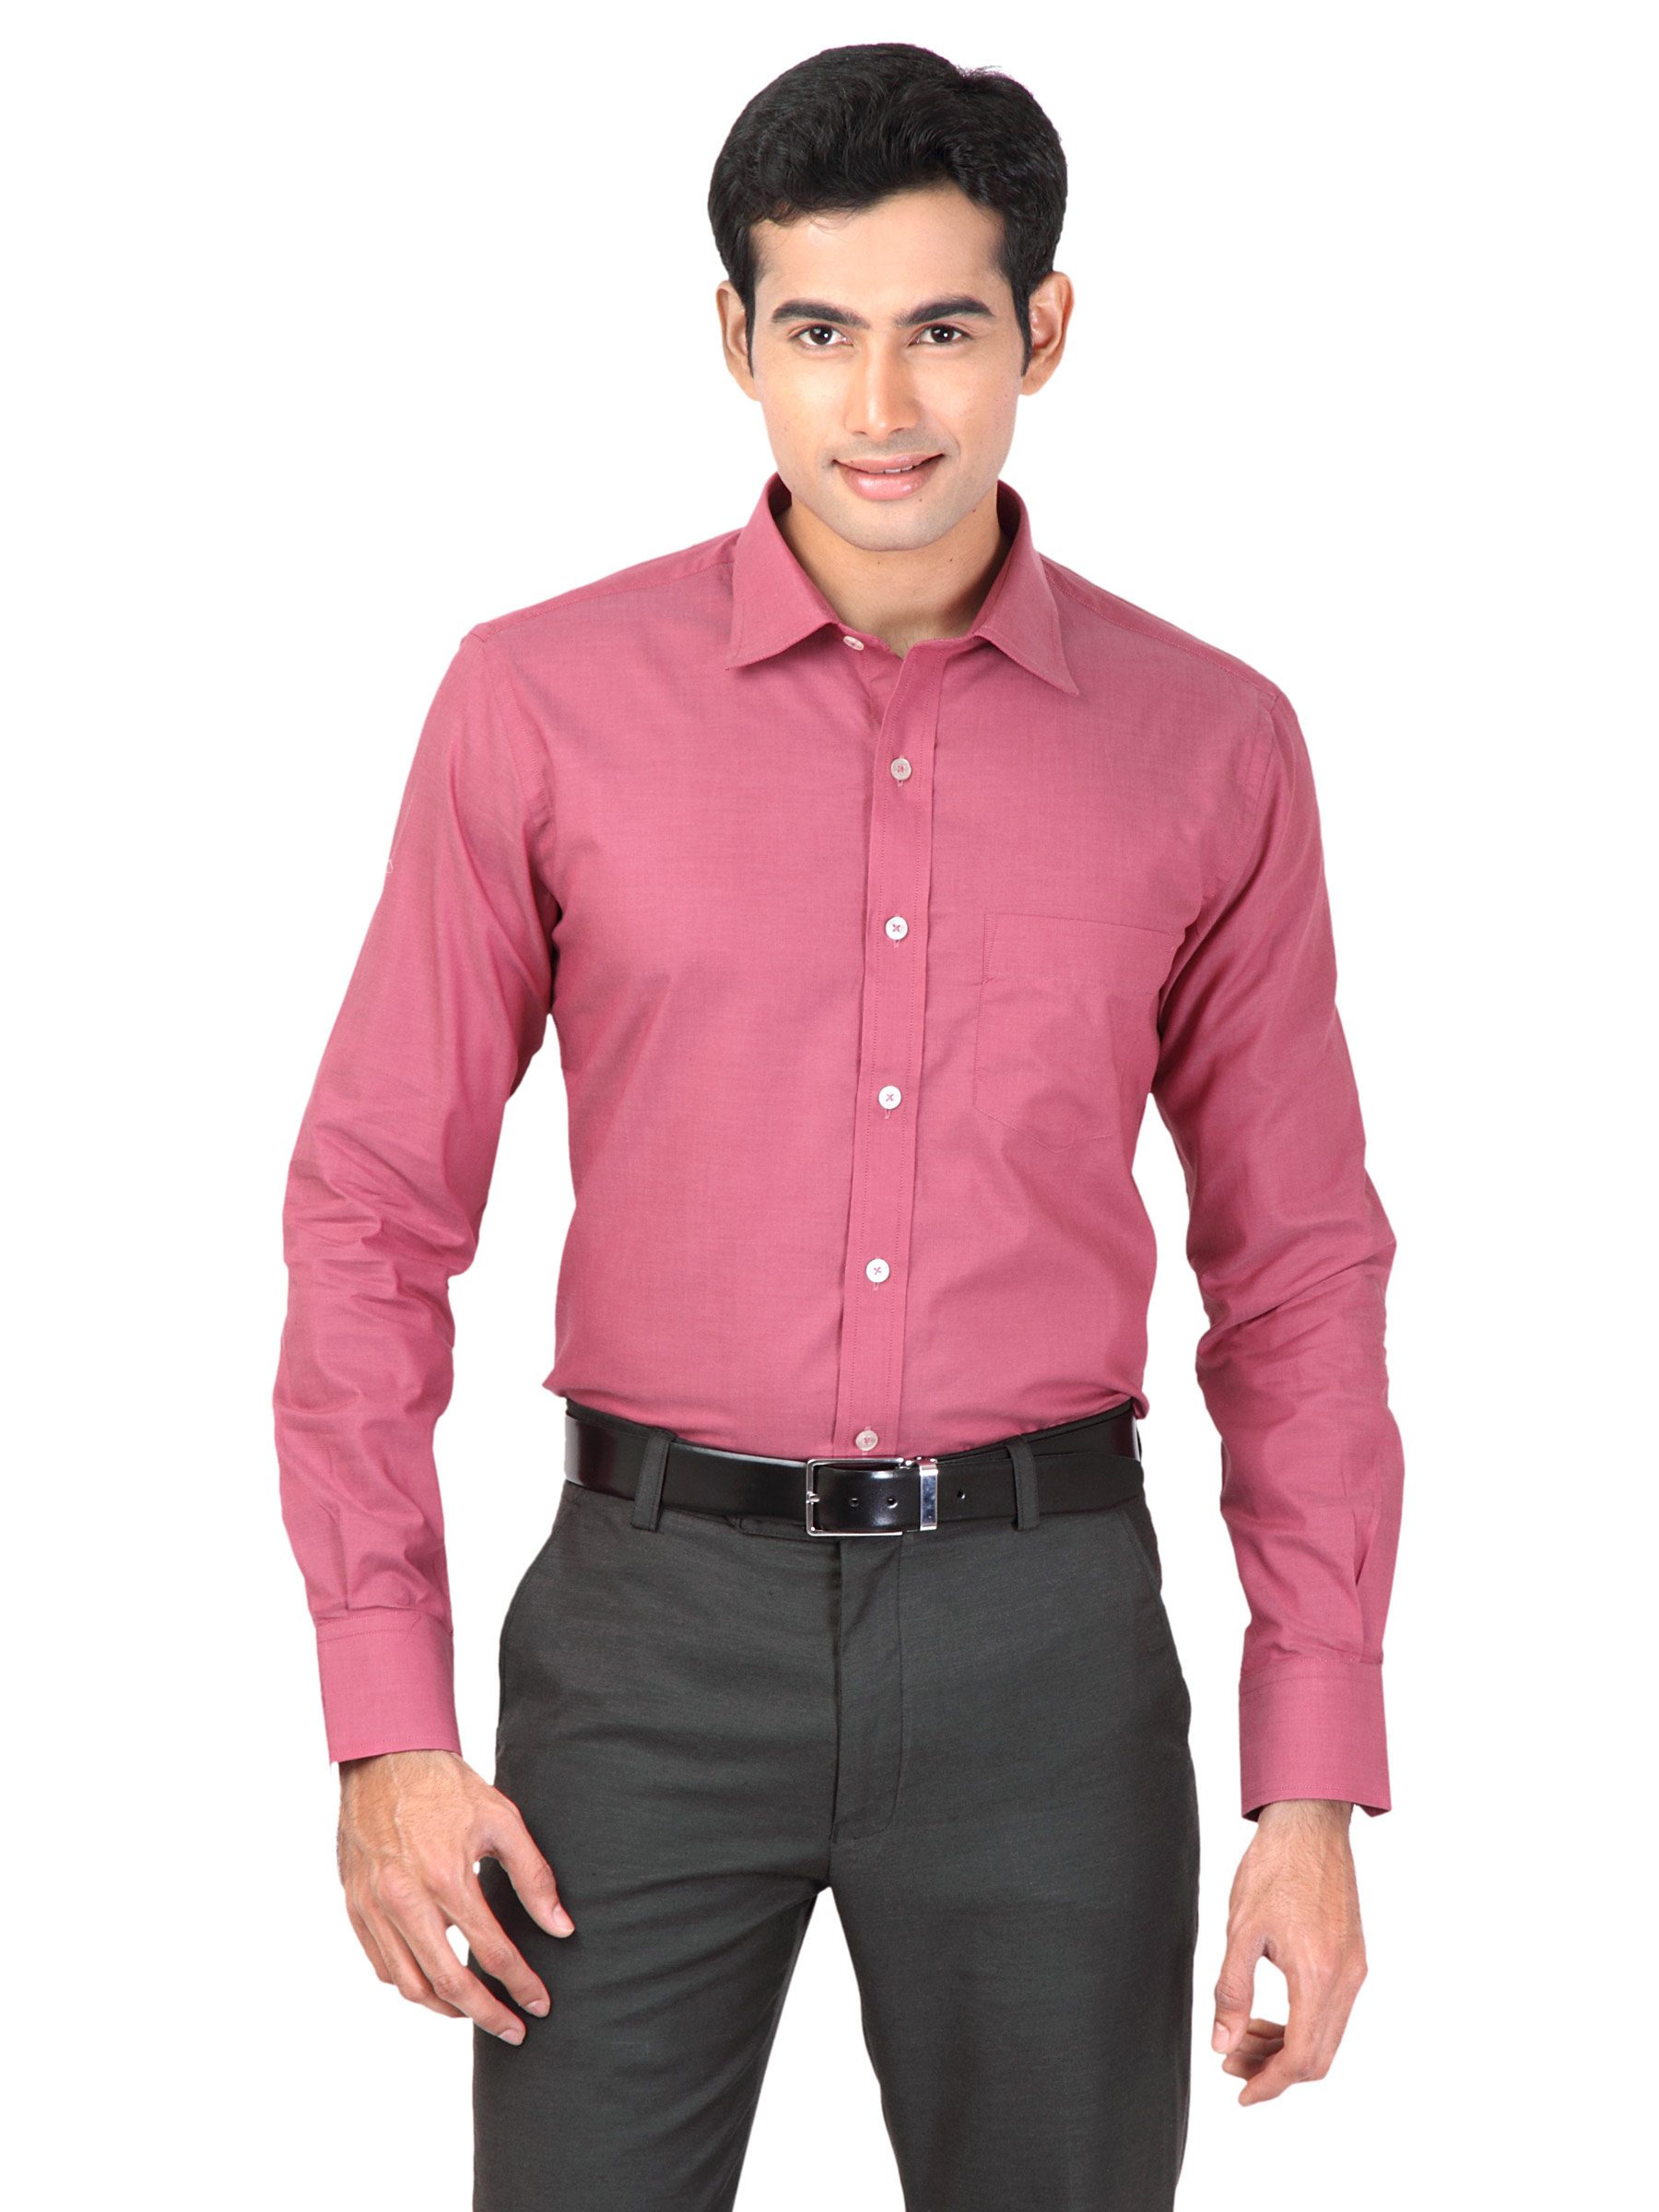

In [12]:
#Viewing an image
print(df_processed['label'][30000])
open_image(base_path/'images'/df_processed['name'][30000])

In [13]:
print(open_image(base_path/'images'/df_processed['name'][77]))

Image (3, 2400, 1800)


In [ ]:
#Saving as csv file
df_100.to_csv("top_100_catagory.csv",index=False)

In [3]:
#Removing less featured labels for better accuracy

df = pd.read_csv('Training_labels/top_80_catagory.csv')
df.head()

,name,label
0,39386.jpg,Jeans-Men-Bottomwear-Apparel
1,21379.jpg,Track Pants-Men-Bottomwear-Apparel
2,53759.jpg,Tshirts-Men-Topwear-Apparel
3,1855.jpg,Tshirts-Men-Topwear-Apparel
4,30805.jpg,Shirts-Men-Topwear-Apparel


In [7]:
# unique categories
len(df.label.unique())

65

In [25]:
#Grouping categories with image count in the dataset
df.label.value_counts().sort_values(ascending=True)

Jackets-Women-Topwear-Apparel                         38
Backpacks-Men-Bags-Accessories                        42
Night suits-Men-Loungewear and Nightwear-Apparel      43
Laptop Bag-Unisex-Bags-Accessories                    43
Shorts-Boys-Bottomwear-Apparel                        46
                                                    ... 
Sports Shoes-Footwear                               1579
Kurtas-Women-Topwear-Apparel                        1586
Men-Shoes-Footwear                                  2286
Shirts-Men-Topwear-Apparel                          2289
Tshirts-Men-Topwear-Apparel                         4223
Name: label, Length: 65, dtype: int64

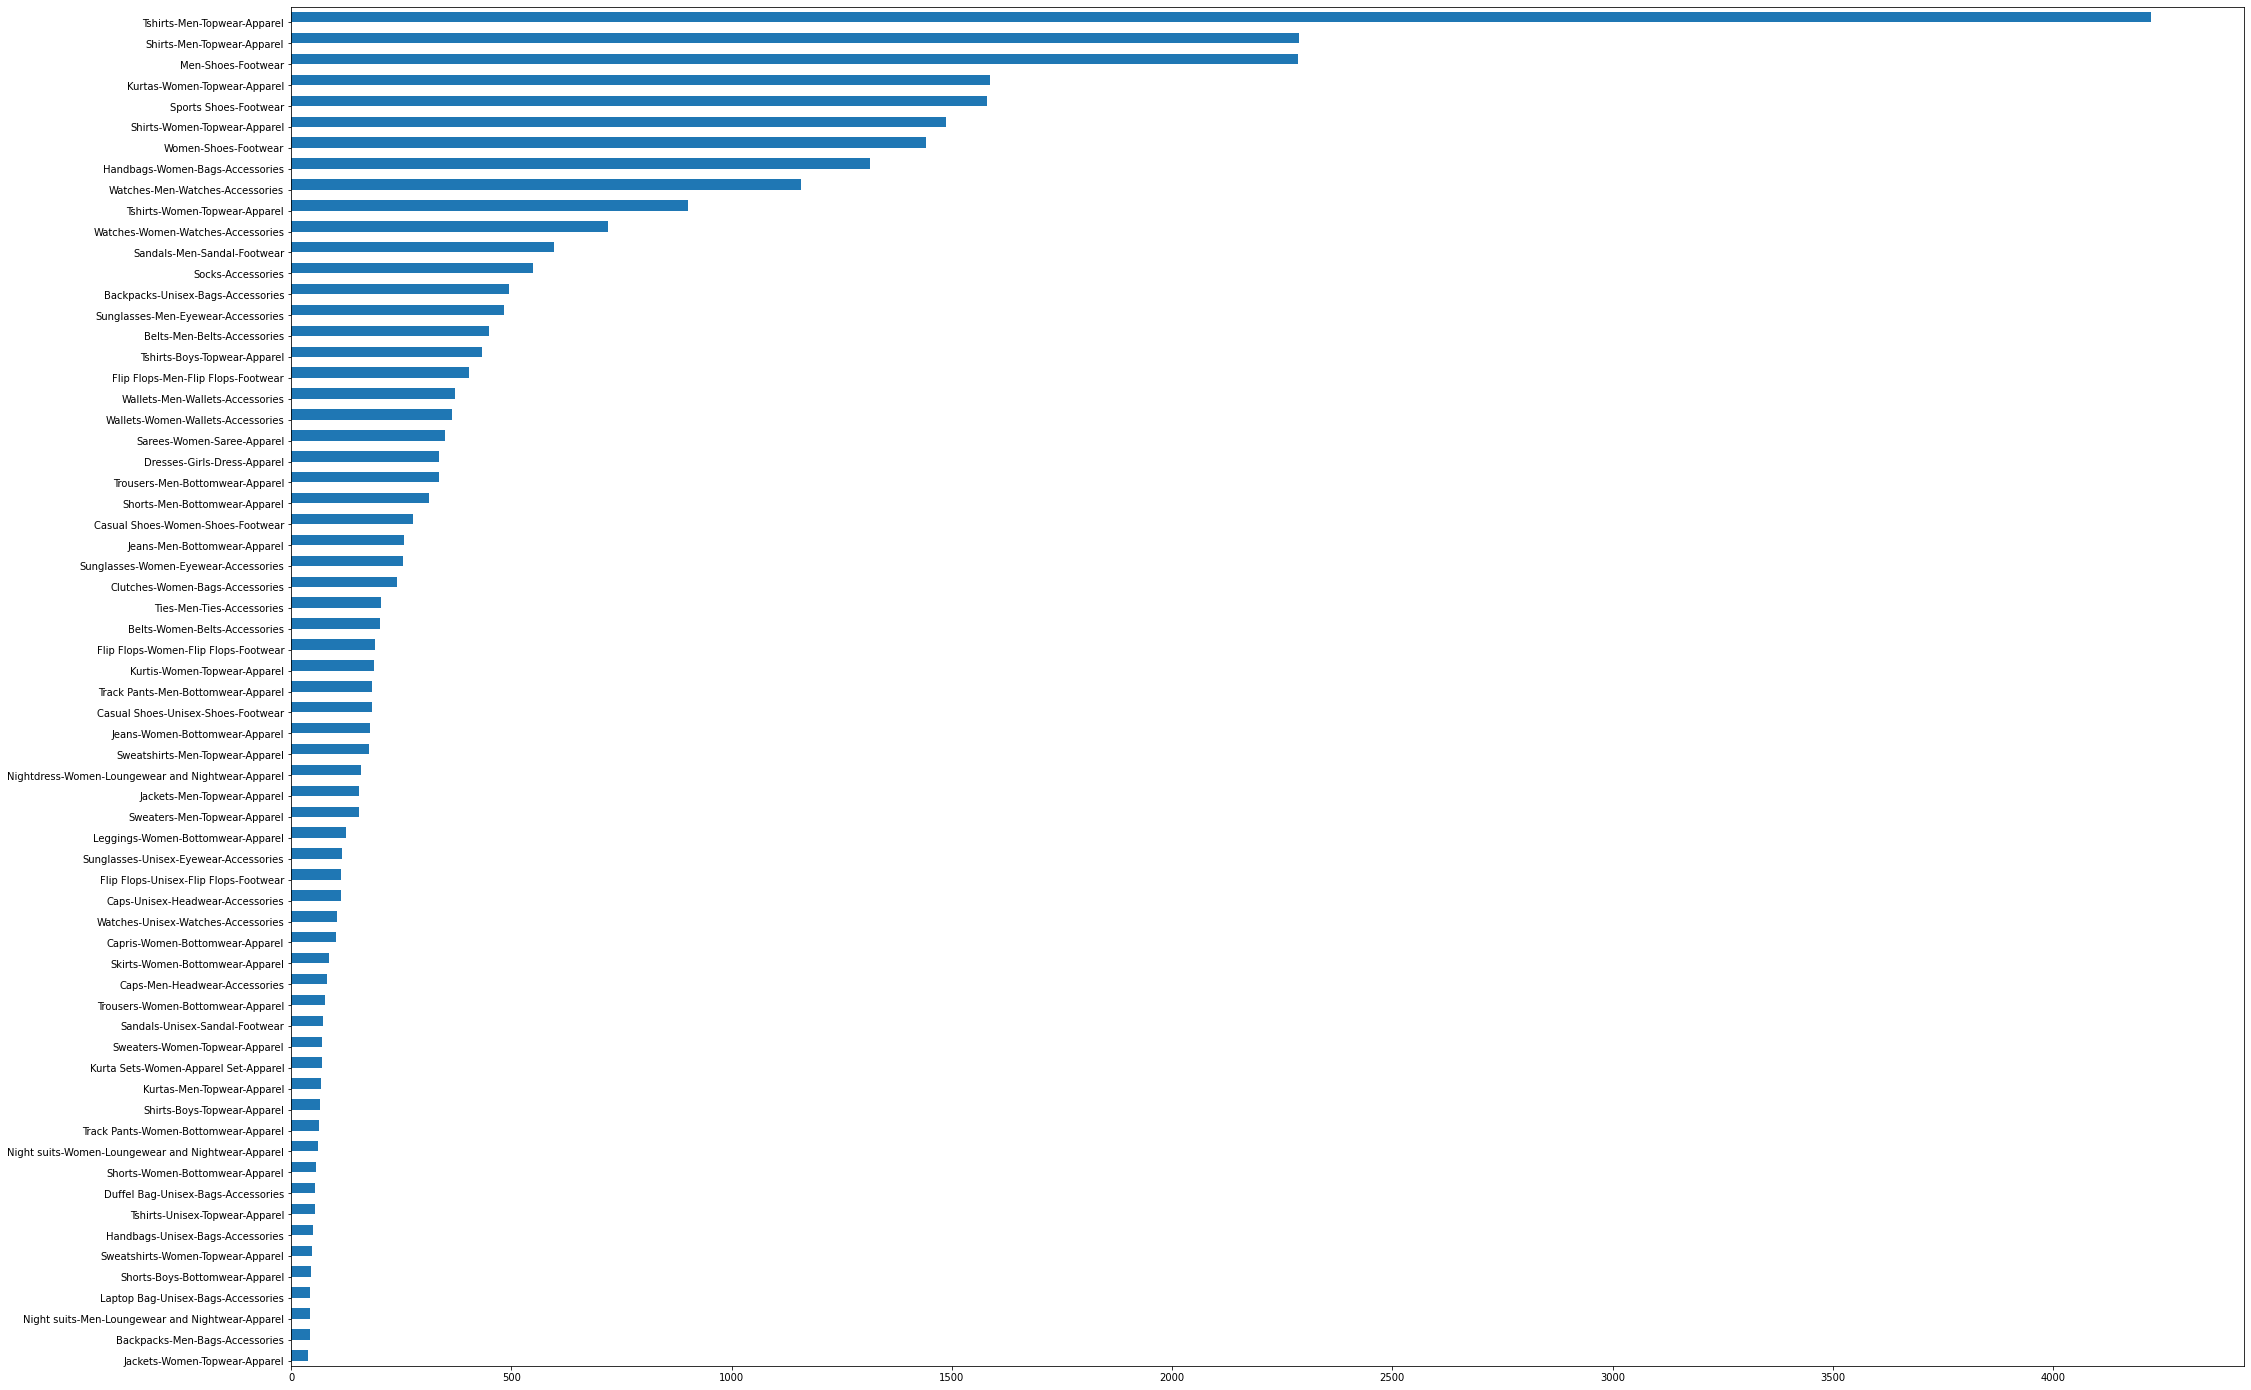

In [53]:

ax = df.label.value_counts().sort_values(ascending=True).plot.barh( x='Number of images',align='edge', width=0.5,figsize=(35,25)).get_figure()


In [55]:
ax.savefig('temp/dataset-distribution.pdf')

In [56]:
#Final dataframe with image and its label
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29324 entries, 0 to 29323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    29324 non-null  object
 1   label   29324 non-null  object
dtypes: object(2)
memory usage: 458.3+ KB
